In [11]:
# SMA Accuracy for the SP500

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split, cross_val_score
import yfinance as yf
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# Download S&P 500 data for daily interval
sp500 = yf.download('^GSPC', period="20y", interval="1d")

# Initialize list to collect results
results_list = []

# Loop through combinations of short and long SMA periods with specific increments
for short_period in range(10, 200, 5):  # Adjusted range for the short SMA period
    for long_period in range(short_period + 5, 201, 5):  # Adjusted range for the long SMA period
        
        # Calculate SMA directly in the loop
        sp500['SMA_Short'] = sp500['Adj Close'].rolling(window=short_period, min_periods=1).mean()
        sp500['SMA_Long'] = sp500['Adj Close'].rolling(window=long_period, min_periods=1).mean()
        sp500['Signal'] = np.where(sp500['SMA_Short'] > sp500['SMA_Long'], 1, -1)
        sp500_cleaned = sp500.dropna()

        # Split data into features and target
        features = sp500_cleaned[['SMA_Short', 'SMA_Long']]
        target = sp500_cleaned['Signal']

        # Normalize features
        scaler = StandardScaler()
        features_scaled = scaler.fit_transform(features)

        # AdaBoost model with reduced number of estimators to mitigate potential overfitting
        model = AdaBoostClassifier(n_estimators=50, random_state=42)

        # Apply cross-validation and calculate mean accuracy
        cv_scores = cross_val_score(model, features_scaled, target, cv=5, scoring='accuracy')
        mean_cv_score = np.mean(cv_scores)

        # Print the current SMA combination and its cross-validated accuracy
        print(f"Short SMA: {short_period}, Long SMA: {long_period}, CV Accuracy: {mean_cv_score:.4f}")

        # Append results to the list
        results_list.append({
            'Short SMA': short_period,
            'Long SMA': long_period,
            'CV Accuracy': mean_cv_score
        })

# Convert results to a DataFrame and sort by cross-validated accuracy
results_df = pd.DataFrame(results_list)
sorted_results_df = results_df.sort_values(by='CV Accuracy', ascending=False).reset_index(drop=True)

# Display top SMA settings by cross-validated accuracy
print(sorted_results_df.head())

# Optionally, export the sorted results to a CSV for further analysis
sorted_results_df.to_csv('sma_daily_sp500_optimization_results.csv', index=False)

In [ ]:
Graphing the best SMA accuracy fit

[*********************100%%**********************]  1 of 1 completed


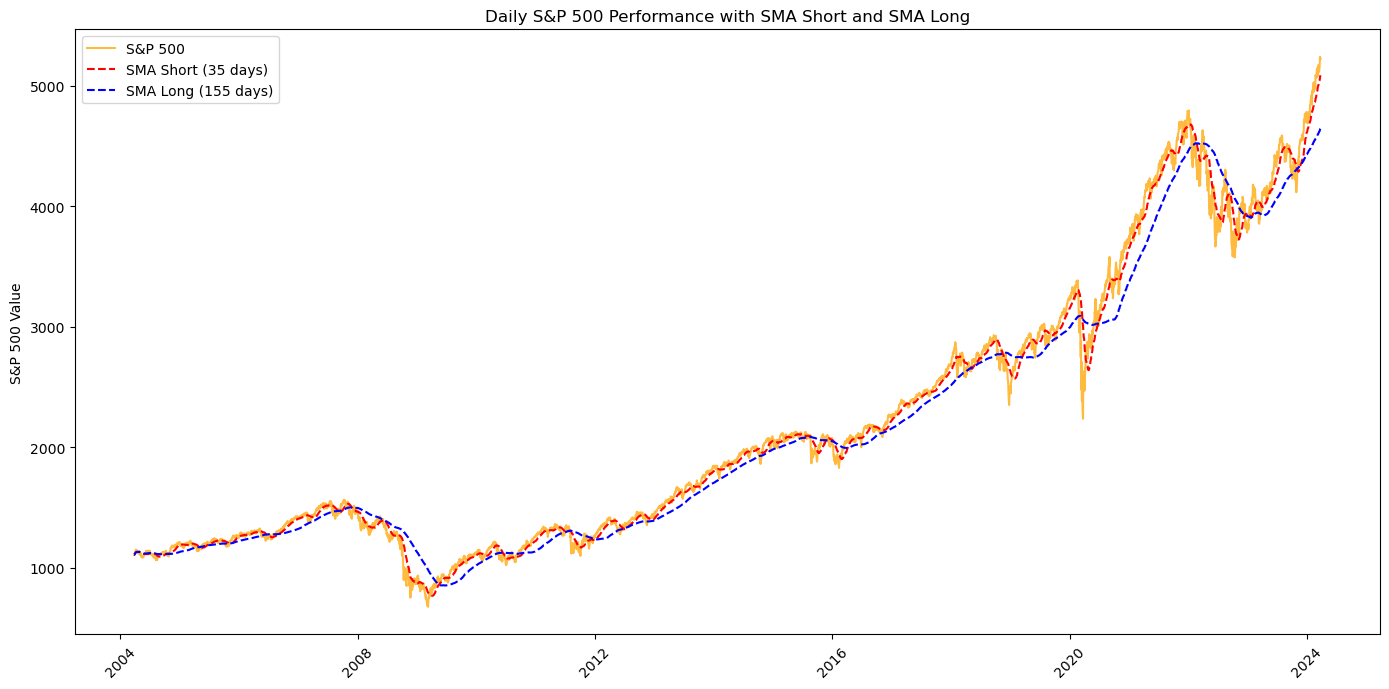

In [10]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Fetch S&P 500 data for 20 years with daily intervals
sp500_daily = yf.download('^GSPC', period="20y", interval="1d")

# Calculate SMA for the daily data
short_window, long_window = 35, 155
sp500_daily['SMA_Short'] = sp500_daily['Adj Close'].rolling(window=short_window, min_periods=1).mean()
sp500_daily['SMA_Long'] = sp500_daily['Adj Close'].rolling(window=long_window, min_periods=1).mean()

# Identify positions (1 for buy, -1 for sell, 0 for hold)
sp500_daily['Position'] = np.where(sp500_daily['SMA_Short'] > sp500_daily['SMA_Long'], 1, 0)
sp500_daily['Position'] = np.where(sp500_daily['SMA_Short'] < sp500_daily['SMA_Long'], -1, sp500_daily['Position'])
sp500_daily['Signal'] = sp500_daily['Position'].diff()

# Filter signals for buy (1) and sell (-1) actions
signals = sp500_daily[sp500_daily['Signal'] != 0][['Signal']]
signals['Action'] = np.where(signals['Signal'] > 0, 'Buy', 'Sell')
signals[['Action']].to_csv('sp500_sma_signals.csv')

# Plotting
fig, ax1 = plt.subplots(figsize=(14, 7))
ax1.xaxis_date()
ax1.xaxis.set_major_locator(mdates.AutoDateLocator())
ax1.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax1.xaxis.get_major_locator()))
plt.xticks(rotation=45)

# Plot S&P 500 values and Moving Averages
ax1.plot(sp500_daily.index, sp500_daily['Adj Close'], color='orange', label='S&P 500', alpha=0.75)
ax1.plot(sp500_daily.index, sp500_daily['SMA_Short'], color='red', label=f'SMA Short ({short_window} days)', linestyle='--')
ax1.plot(sp500_daily.index, sp500_daily['SMA_Long'], color='blue', label=f'SMA Long ({long_window} days)', linestyle='--')

ax1.set_ylabel('S&P 500 Value', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.legend(loc='upper left')

plt.title('Daily S&P 500 Performance with SMA Short and SMA Long')
plt.tight_layout()
plt.show()




In [ ]:
# RSI Slope Accuracy for the SP500

In [ ]:
import yfinance as yf
from scipy.stats import linregress
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import warnings

warnings.filterwarnings('ignore')

def calculate_rsi(data, window):
    delta = data.diff()
    gain = (delta > 0) * delta
    loss = (-delta > 0) * delta
    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def analyze_rsi_period(period, data):
    data['RSI'] = calculate_rsi(data['Adj Close'], window=period)
    data['RSI_Slope'] = data['RSI'].rolling(window=5).apply(lambda x: linregress(range(len(x)), x).slope if not x.isnull().any() else np.nan)
    data['Trade_Signal'] = np.where(data['RSI_Slope'] > 0, 1, 0)
    data['Future_Returns'] = data['Adj Close'].shift(-1) - data['Adj Close']
    data['Correct'] = np.where(data['Future_Returns'] > 0, 1, 0)
    data.dropna(inplace=True)

    if len(data) < 10:
        return None

    X = data[['RSI', 'RSI_Slope']]
    y = data['Correct']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    clf = AdaBoostClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)
    predictions = clf.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    
    return period, accuracy

# Download S&P 500 data
sp500 = yf.download('^GSPC', period="20y", interval="1d")

results = []

# Iterate RSI periods from 3 to 40
for period in range(3, 41):
    result = analyze_rsi_period(period, sp500.copy())
    if result is not None:
        results.append({'Period': result[0], 'Accuracy': result[1]})

# Convert results to DataFrame and sort by accuracy
results_df = pd.DataFrame(results).sort_values(by='Accuracy', ascending=False).reset_index(drop=True)

# Display top RSI settings by accuracy
print(results_df.head())

# Export the sorted results to a CSV file
results_df.to_csv('rsi_daily_sp500_optimization_results.csv', index=False)

[*********************100%%**********************]  1 of 1 completed


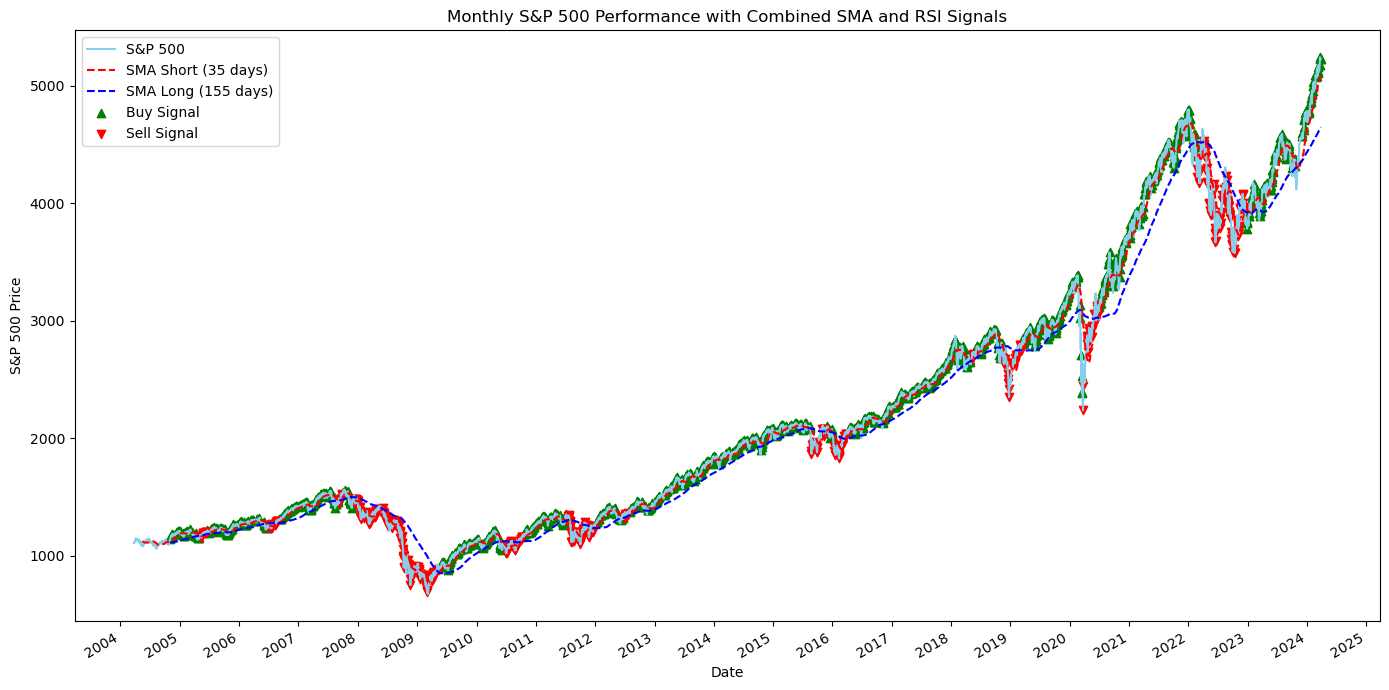

In [14]:
import pandas as pd
import numpy as np
import yfinance as yf
from scipy.stats import linregress
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Fetch S&P 500 data for 20 years with monthly intervals
sp500 = yf.download('^GSPC', period="20y", interval="1d")

# Function to calculate RSI
def calculate_rsi(series, period=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Function to calculate SMA
def calculate_sma(data, window):
    return data.rolling(window=window).mean()

# Calculate SMA for short and long windows
short_window = 35
long_window = 155
sp500['SMA_Short'] = calculate_sma(sp500['Adj Close'], short_window)
sp500['SMA_Long'] = calculate_sma(sp500['Adj Close'], long_window)

# Calculate RSI for the S&P 500
sp500['RSI'] = calculate_rsi(sp500['Adj Close'], period=14)

# Determine the slope of RSI over the last 5 periods
sp500['RSI_Slope'] = sp500['RSI'].rolling(window=5).apply(lambda x: linregress(range(len(x)), x).slope)

# Determine combined buy and sell signals
# Signal is 'Buy' if SMA Short crosses above SMA Long AND RSI > 30 with a positive slope (weighted decision)
# Signal is 'Sell' if SMA Short crosses below SMA Long AND RSI < 70 with a negative slope (weighted decision)
sp500['Signal'] = np.where((sp500['SMA_Short'] > sp500['SMA_Long']) & (sp500['RSI'] > 30) & (sp500['RSI_Slope'] > 0), 'Buy',
                           np.where((sp500['SMA_Short'] < sp500['SMA_Long']) & (sp500['RSI'] < 70) & (sp500['RSI_Slope'] < 0), 'Sell', np.nan))

# Filter for buy and sell signals
signals = sp500.dropna(subset=['Signal'])

# Save signals to CSV including the stock price
signals[['Adj Close', 'Signal']].to_csv('sp500_monthly_combined_signals.csv')

# Plotting
plt.figure(figsize=(14, 7))
ax = plt.gca()

# Configure x-axis to display dates correctly
ax.xaxis_date()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Plot S&P 500, SMA, and signals
sp500['Adj Close'].plot(ax=ax, color='skyblue', label='S&P 500')
sp500['SMA_Short'].plot(ax=ax, color='red', label=f'SMA Short ({short_window} days)', linestyle='--')
sp500['SMA_Long'].plot(ax=ax, color='blue', label=f'SMA Long ({long_window} days)', linestyle='--')
plt.scatter(signals.index[signals['Signal'] == 'Buy'], signals['Adj Close'][signals['Signal'] == 'Buy'], label='Buy Signal', marker='^', color='green', alpha=1)
plt.scatter(signals.index[signals['Signal'] == 'Sell'], signals['Adj Close'][signals['Signal'] == 'Sell'], label='Sell Signal', marker='v', color='red', alpha=1)

plt.title('Monthly S&P 500 Performance with Combined SMA and RSI Signals')
plt.xlabel('Date')
plt.ylabel('S&P 500 Price')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Breaking Down ETFs

In [ ]:
import yfinance as yf
import pandas as pd

# Define ETFs and Indexes with descriptions
etfs_and_indexes = {
    "VGT": "Vanguard Information Technology ETF",
    "VHT": "Vanguard Health Care ETF",
    "VFH": "Vanguard Financials ETF",
    "VDE": "Vanguard Energy ETF",
    "VIS": "Vanguard Industrials ETF",
    "VDC": "Vanguard Consumer Staples ETF",
    "VCR": "Vanguard Consumer Discretionary ETF",
    "VPU": "Vanguard Utilities ETF",
    "VAW": "Vanguard Materials ETF",
    "VNQ": "Vanguard Real Estate ETF",
    "VOX": "Vanguard Communication Services ETF",
    "VIG": "Vanguard Dividend Appreciation ETF",
    "VYM": "Vanguard High Dividend Yield ETF",
    "VWO": "Vanguard Emerging Markets Stock ETF",
    "VEA": "Vanguard FTSE Developed Markets ETF",
    "VB": "Vanguard Small-Cap ETF",
    "VBR": "Vanguard Small-Cap Value ETF",
    "VTV": "Vanguard Value ETF",
    "BND": "Vanguard Total Bond Market ETF",
    "BNDX": "Vanguard Total International Bond ETF",
    "BIV": "Vanguard Intermediate-Term Bond ETF",
    "BLV": "Vanguard Long-Term Bond ETF",
    "BSV": "Vanguard Short-Term Bond ETF",
    "VCIT": "Vanguard Intermediate-Term Corporate Bond ETF",
    "VCSH": "Vanguard Short-Term Corporate Bond ETF",
    "VCLT": "Vanguard Long-Term Corporate Bond ETF",
    "VGIT": "Vanguard Intermediate-Term Treasury ETF",
    "VGSH": "Vanguard Short-Term Treasury ETF",
    "VGLT": "Vanguard Long-Term Treasury ETF",
    "VMBS": "Vanguard Mortgage-Backed Securities ETF",
    "VTEB": "Vanguard Tax-Exempt Bond ETF",
    "HYG": "iShares iBoxx $ High Yield Corporate Bond ETF",
    "LQD": "iShares iBoxx $ Investment Grade Corporate Bond ETF",
    "SHY": "iShares 1-3 Year Treasury Bond ETF",
    "IEF": "iShares 7-10 Year Treasury Bond ETF",
    "TLT": "iShares 20+ Year Treasury Bond ETF",
    "MUB": "iShares National Muni Bond ETF",
    "EMB": "iShares J.P. Morgan USD Emerging Markets Bond ETF",
    "AGG": "iShares Core U.S. Aggregate Bond ETF",
    "^GSPC": "S&P 500 Index"
}

# Initialize DataFrame to hold all data
all_data = pd.DataFrame()

for symbol, description in etfs_and_indexes.items():
    # Download historical data
    data = yf.download(symbol, start="2003-01-01", end="2023-01-01")
    
    # Calculate moving averages
    data['50_day_MA'] = data['Adj Close'].rolling(window=50).mean()
    data['200_day_MA'] = data['Adj Close'].rolling(window=200).mean()
    
    # Determine "Buy" or "Sell" based on moving averages
    data['Action'] = data.apply(lambda row: "Buy" if row['50_day_MA'] > row['200_day_MA'] else "Sell", axis=1)
    
    # Add symbol and description columns
    data['Symbol'] = symbol
    data['Description'] = description
    
    # Keep only necessary columns
    data = data[['Adj Close', '50_day_MA', '200_day_MA', 'Action', 'Symbol', 'Description']]
    
    # Append to the all_data DataFrame
    all_data = pd.concat([all_data, data])

# Reset index and sort
all_data.reset_index(inplace=True)
all_data.sort_values(by=['Date', 'Symbol'], inplace=True)

# Export to CSV
all_data.to_csv("all_etfs_and_indexes_data_with_descriptions_and_action.csv", index=False)

print("Data has been successfully exported to all_etfs_and_indexes_data_with_descriptions_and_action.csv")


In [ ]:
# Getting ETFs Accuracy of SMA Windows

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
import random
import warnings

# Suppress warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=FutureWarning)

# Load the dataset
df_original = pd.read_csv('all_etfs_and_indexes_data_with_descriptions_and_action_sorted.csv')
df_original['Date'] = pd.to_datetime(df_original['Date'])
df_original.set_index('Date', inplace=True)

# Prepare a list to collect rows
results_list = []

# Get unique symbols
symbols = df_original['Symbol'].unique()

for symbol in symbols:
    df_symbol = df_original[df_original['Symbol'] == symbol]
    
    for i in range(100):  # Adjust as needed
        short_window = random.randint(3, 130)
        long_window = random.randint(short_window + 1, 140)
        print(f"Symbol: {symbol}, Trying window settings: short={short_window}, long={long_window}.")

        df = df_symbol.copy()
        df['short_mavg'] = df['Adj Close'].rolling(window=short_window, min_periods=1).mean()
        df['long_mavg'] = df['Adj Close'].rolling(window=long_window, min_periods=1).mean()
        df['signal'] = np.where(df['short_mavg'] > df['long_mavg'], 1, -1)
        df['actual_returns'] = df['Adj Close'].pct_change()
        df.dropna(inplace=True)

        if df.empty:
            continue

        # Define training and testing sets
        training_window_end = df.index.min() + pd.DateOffset(years=1)
        testing_window_start = training_window_end + pd.DateOffset(days=1)

        X = df[['short_mavg', 'long_mavg']]
        y = df['signal']
        X_train = X.loc[:training_window_end]
        y_train = y.loc[:training_window_end]
        X_test = X.loc[testing_window_start:]
        y_test = y.loc[testing_window_start:]

        if X_train.empty or X_test.empty:
            continue

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        model = AdaBoostClassifier()
        model.fit(X_train_scaled, y_train)
        predictions = model.predict(X_test_scaled)
        accuracy = accuracy_score(y_test, predictions)

        # Collect results
        results_list.append({
            'Symbol': symbol, 
            'Short Window': short_window, 
            'Long Window': long_window, 
            'Accuracy': accuracy
        })

# Sort the DataFrame first by 'Symbol' in ascending order, then by 'Accuracy' in descending order
sorted_results_df = results_df.sort_values(by=['Symbol', 'Accuracy'], ascending=[True, False])

display(sorted_results_df)

# Export the sorted DataFrame to a CSV file
sorted_results_df.to_csv('strategy_results_adaboost_across_symbols.csv', index=False)
print("AdaBoost results summary saved to strategy_results_adaboost_across_symbols.csv")

# Group by 'Symbol' and get the row with the highest 'Accuracy' for each symbol
highest_accuracy_per_symbol = results_df.loc[results_df.groupby('Symbol')['Accuracy'].idxmax()]

# Export the DataFrame with the highest accuracy per symbol to a CSV file
highest_accuracy_per_symbol.to_csv('highest_accuracy_per_symbol.csv', index=False)
print("Highest accuracy per symbol saved to highest_accuracy_per_symbol.csv")